# DESCRIPTION

In this notebook, part of the graphics inserted in several figures of the paper are obtained.

In [1]:
import re
import warnings
import pandas as pd
import nibabel as nb
import pickle
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import seaborn as sns
import numpy as np
import pandas as pd
import scipy.stats as st
from sklearn.metrics import r2_score, mean_squared_error
from itertools import combinations
from scipy.stats import ttest_ind

warnings.filterwarnings('ignore')
display(HTML("<style>:root { --jp-notebook-max-width: 100% !important; }</style>"))
display(HTML("<style>.container { width:100% !important; }</style>"))
# Environment settings:
pd.set_option('display.max_column', 50)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 1000)


In [2]:
# helper functions
def region_order(df,total):
    # Region order by count
    df.columns = [str(col) for col in df.columns]
    region_order = df.groupby('Region').agg({"0": sum})
    region_order.reset_index(drop=False,inplace=True)
    region_order = region_order.sort_values(by="0", ascending=False, ignore_index=True)
    region_order.rename(columns={"0":"count"},inplace=True)
    region_order["Global_%Contribution_by_Region"]=100*region_order["count"]/total
    return list(region_order["Region"])

def conf_interval(x):
    st_interval = st.t.interval(0.95, len(x) -1, loc=np.mean(x), scale=st.sem(x))
    return list((len(x), np.mean(x),st.sem(x), st_interval))

def conf_interval_computation(df=None, grop_by_cols=None, value_col_name=None):
    df_mean_ci = df.groupby(grop_by_cols)[value_col_name].apply(lambda x:conf_interval(x.values)).reset_index()
    df_mean_ci[["N",'Mean',"Standard_Error", 'CI']] = pd.DataFrame(df_mean_ci[value_col_name].tolist(), index= df_mean_ci.index)
    df_mean_ci.drop([value_col_name], axis=1, inplace=True)
    df_mean_ci.sort_values(by=grop_by_cols,inplace=True)
    return df_mean_ci[grop_by_cols+["N",'Mean',"Standard_Error", 'CI']]

def ttest_ind_groups_combinations(df=None, grop_by_cols=None, value_col_name=None):
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html
    df['Group'] = df[grop_by_cols].astype('str').T.agg('-'.join)
    grps = df['Group'].unique()
    combs = combinations(grps, 2)
    # perform Welch’s t-test
    ttests = {
        f'{c1}___{c2}': [ttest_ind(df.loc[df['Group'] == c1, value_col_name], df.loc[df['Group'] == c2, value_col_name],equal_var=False),
                       ttest_ind(df.loc[df['Group'] == c1, value_col_name], df.loc[df['Group'] == c2, value_col_name],equal_var=False).confidence_interval(confidence_level=0.95)]for c1, c2 in combs
    }
    ttests_df = pd.DataFrame(ttests.items(), columns=['Groups_Combination', 'ttest_ind'])
    ttests_df[['statistic-pvalue','CI']] = pd.DataFrame(ttests_df['ttest_ind'].tolist(), index= ttests_df.index)
    ttests_df[['statistic', 'pvalue']] = pd.DataFrame(ttests_df['statistic-pvalue'].tolist(), index= ttests_df.index)
    ttests_df[['Group1', 'Group2']] = ttests_df['Groups_Combination'].str.split('___', expand=True)
    ttests_df.drop(['Groups_Combination',"ttest_ind", "statistic-pvalue"], axis=1, inplace=True)
    ttests_df['reject'] = ttests_df['pvalue'] < 0.05
    print(ttests_df["reject"].value_counts(dropna=False))
    return ttests_df[["Group1",	"Group2", "CI",	"statistic", "pvalue", "reject"]]


def compute_mask_volume(path):
    """compute_mask_volume"""
    img = nb.load(path)  # path is contains a path to an example nifti mask
    return nb.imagestats.mask_volume(img)

def compute_region_dic_vol(dic_region, df_full_vol):
    region_dic_vol = {}
    for region,list_of_regions in dic_region.items():
        region_dic_vol[region] = df_full_vol[df_full_vol["Region"].isin(list_of_regions)]["volume"].sum()   
    return region_dic_vol 

def compute_comb_region_mean(list_of_regions = [], full_mean_voxel_dic = {}):
    # This function calculates the mean value between all regions in the list_of_regions 
    # using values from full_mean_voxel_dic following a formula that involves
    # the Mean and Voxel_Count values of all regions
    sum_total_Summation = 0
    voxel_total_Summation = 0
    sum_total_HistEqualized = 0
    voxel_total_HistEqualized = 0
    
    for region in list_of_regions:
        sum_total_Summation += full_mean_voxel_dic[region]["Summation"]['Mean']*full_mean_voxel_dic[region]["Summation"]['Voxel_Count']
        voxel_total_Summation += full_mean_voxel_dic[region]["Summation"]['Voxel_Count']
        sum_total_HistEqualized += full_mean_voxel_dic[region]["HistEqualized"]['Mean']*full_mean_voxel_dic[region]["HistEqualized"]['Voxel_Count']
        voxel_total_HistEqualized += full_mean_voxel_dic[region]["HistEqualized"]['Voxel_Count']
        
    return sum_total_Summation/voxel_total_Summation, sum_total_HistEqualized/voxel_total_HistEqualized

def compute_region_dic_mean(dic_region, full_mean_voxel_dic):
    region_dic_vol = {}
    for region,list_of_regions in dic_region.items():
        mean_perfusion_Summation, mean_perfusion_HistEqualized  = compute_comb_region_mean(list_of_regions, full_mean_voxel_dic)
        region_dic_vol[region] = {"mean_perfusion_Summation": mean_perfusion_Summation,
                                  "mean_perfusion_HistEqualized": mean_perfusion_HistEqualized}
    region_dic_df = pd.DataFrame([[key,value['mean_perfusion_Summation'],value['mean_perfusion_HistEqualized']] for key,value in region_dic_vol.items()],columns=['Region', 'mean_perfusion_Summation', 'mean_perfusion_HistEqualized'])
    return region_dic_df

def print_barplot_values(barplot_output):
    labels = []
    hue_labels = [label for label in barplot_output.get_legend_handles_labels()[1]]
    y_labels = [label.get_text() for label in barplot_output.get_yticklabels()]
    
    for hue_label in hue_labels:
        for y_label in y_labels:
            labels = labels + [hue_label + "_" + y_label]
 
    val_means = [bar.get_width() for bar in barplot_output.patches]
    low_cis = [line.get_xdata()[0] for line in barplot_output.lines]
    upp_cis = [line.get_xdata()[1] for line in barplot_output.lines]
    
    print("{:<60} {:<20} {:<20} {:<20}".format("Bar", "mean", "low_ci", "upp_ci"))
    for label, val_mean, low_ci, upp_ci in zip(labels,val_means,low_cis, upp_cis):
        print("{:<60} {:<20} {:<20} {:<20}".format(label, val_mean, low_ci, upp_ci))


def get_unique_patient_and_roi(df,regions_dic, mets_total, patients_total):
    df_grouped = df[df["Expansion (mm)"]==0].copy()
    df_grouped.reset_index(drop=True, inplace=True)
    df_grouped = df_grouped.groupby(by=["Institution", "PRIMARY", "MRN", "ROI", "Expansion (mm)"],sort=False, observed=True, dropna=False).sum(numeric_only=True)
    df_grouped = df_grouped[list(set(df_grouped.columns)-set(['Volume (mm3)','GM to Centroid (mm)', 'GM to ROI (mm)', 'Sphericity', 'GMtoSurface']))].copy()
    df_grouped = df_grouped.stack().unstack(level=4)
    df_grouped.reset_index(inplace=True)
    df_grouped.index.names = ['']
    df_grouped.columns.names = ['']
    df_grouped.rename(columns={"level_4": "Region"}, inplace=True)
    df_grouped_atlas = df_grouped[df_grouped["Region"].isin(combo_regions_dic.keys())].copy()
    df_grouped_atlas.reset_index(drop=True, inplace=True)
    df_grouped_atlas_positive =  df_grouped_atlas[df_grouped_atlas[0]>0].copy()
    df_grouped_atlas_positive.reset_index(drop=True, inplace=True)
    df_grouped_atlas_positive.sort_values(["Institution", "PRIMARY", "MRN", "ROI", "Region", 0], inplace=True, ascending=[False, False, False, False, False, False], ignore_index=True)
    print("Unique Patients Total:",len(df_grouped_atlas_positive[["Institution","PRIMARY", "MRN"]].value_counts()), "of", patients_total, 
          "Unique ROI Total:",len(df_grouped_atlas_positive[["Institution","PRIMARY", "MRN", "ROI"]].value_counts()), "of", mets_total)
    df_unique_patients = df_grouped_atlas_positive[["Institution","PRIMARY", "MRN"]].value_counts().to_frame()
    df_unique_patients.reset_index(drop=False, inplace=True)
    print ("Unique Patients by Primary:\n",df_unique_patients["PRIMARY"].value_counts())
    df_unique_roi = df_grouped_atlas_positive[["Institution","PRIMARY", "MRN", "ROI"]].value_counts().to_frame()
    df_unique_roi.reset_index(drop=False, inplace=True)
    print ("Unique ROIs by Primary:\n", df_unique_roi["PRIMARY"].value_counts()) 

In [3]:
# Selecting the case
case = ["Melanoma", "Lung", "Breast"]
mets_total=10398
patients_total= 2305

## Figure 2 - B & C

Figure 2 - B


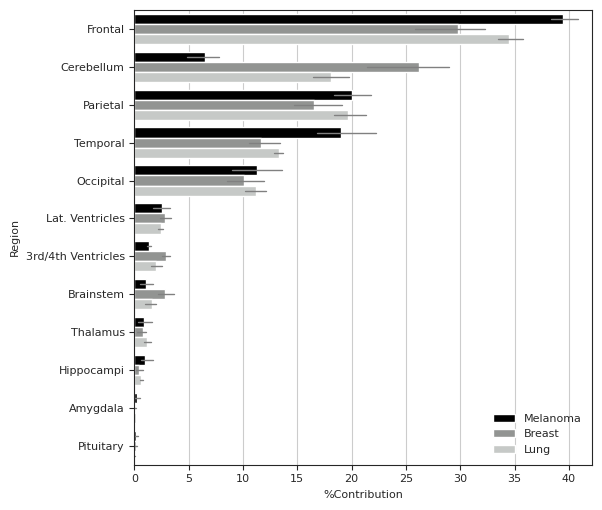

Bar                                                          mean                 low_ci               upp_ci              
Melanoma_Frontal                                             39.42488276394022    38.35725141419336    40.802453150014124  
Melanoma_Cerebellum                                          6.514666645204039    4.847769456203191    7.771668118466899   
Melanoma_Parietal                                            20.059620072246798   18.35856941278628    21.760670731707318  
Melanoma_Temporal                                            19.037423708394176   16.843040775967605   22.229925800764033  
Melanoma_Occipital                                           11.276138845333307   9.001095846801842    13.551181843864772  
Melanoma_Lat. Ventricles                                     2.5216097108085793   1.7448824041811846   3.295614892000434   
Melanoma_3rd/4th Ventricles                                  1.3005191379511831   1.121809963273378    1.5016621363502791  
Melanoma

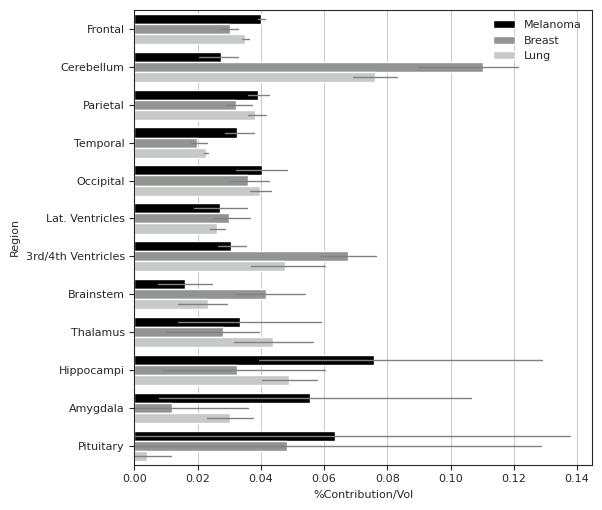

Bar                                                          mean                 low_ci               upp_ci              
Melanoma_Frontal                                             0.04013270325118125  0.039048540922499445 0.04121686557986305 
Melanoma_Cerebellum                                          0.0274189768608359   0.020403327719639472 0.032709453900793724
Melanoma_Parietal                                            0.03914194408458953  0.03582271722197425  0.0424611709472048  
Melanoma_Temporal                                            0.032465796659516905 0.028723568132772374 0.037910184794885275
Melanoma_Occipital                                           0.04022968328017475  0.03211305217664965  0.04834631438369985 
Melanoma_Lat. Ventricles                                     0.027189218709860324 0.0188141682302835   0.03553491791294685 
Melanoma_3rd/4th Ventricles                                  0.03055659260710935  0.026357697499433175 0.03528258584972807 
Melanoma

In [4]:
print("Figure 2 - B")
df_to_plot = pd.read_csv('./Fig/Figure_2_B.csv')
order = region_order(df_to_plot,total=mets_total)
sns.set_style("ticks", {'axes.grid': True})
f, ax = plt.subplots(figsize=(15*0.393701, 15*0.393701)) 
ax = sns.barplot(data=df_to_plot, y="Region", hue="PRIMARY", x="%_0", palette=["black", "#929591", "#C5C9C7"], errwidth=1, errcolor="#808080", order=order)
ax.legend(ncol=1, loc="lower right", frameon=False, fontsize=8)
ax.set_xlim(0, df_to_plot["%_0"].max()+1)
ax.set_xlabel("%Contribution", fontsize=8)
ax.set_ylabel("Region", fontsize=8)
ax.tick_params(labelsize=8)
plt.savefig('./Fig/Figure_2_B.eps', bbox_inches="tight")
plt.savefig('./Fig/Figure_2_B.png', bbox_inches="tight")
plt.show()
print_barplot_values(ax)  


print("Figure 2 - C")
df_to_plot = pd.read_csv('./Fig/Figure_2_C.csv')
sns.set_style("ticks", {'axes.grid': True})
f, ax = plt.subplots(figsize=(15*0.393701, 15*0.393701))
sns.barplot(y=df_to_plot["Region"], x=df_to_plot["%_0_vol"], hue=df_to_plot["PRIMARY"],
            data=df_to_plot, palette=["black", "#929591", "#C5C9C7"], errwidth=1, errcolor="#808080", order=order)
ax.legend(ncol=1, loc="best", frameon=False,
          fontsize=8)
ax.set_xlabel("%Contribution/Vol", fontsize=8)
ax.set_ylabel("Region", fontsize=8)
ax.tick_params(labelsize=8)
plt.savefig("./Fig/Figure_2_C.eps", bbox_inches="tight")
plt.savefig("./Fig/Figure_2_C.png", bbox_inches="tight")
plt.show()
print_barplot_values(ax)  

In [5]:
# df_to_plot.to_csv('./Fig/'+"Figure_2_C"+'.csv')

# Figure 2 D

Figure 2 - D


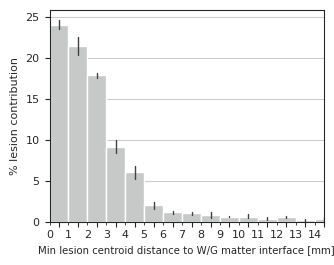

In [6]:
# Minimun lesion centroid distance to W/G matter junction
# % of the lesion contribution vs Minimun lesion centroid distance to W/G matter junction
# None : if the volume of the structure was zero or if the structure was outside of the atlas structures
# This graph only consider lesions with the "GM to Centroid (mm)" is not None

print("Figure 2 - D")
#df_hist_plot.to_csv('./Fig/Figure_2_D.csv')
df_hist_plot = pd.read_csv('./Fig/Figure_2_D.csv')
sns.set_style("ticks", {'axes.grid': True})
f, ax = plt.subplots(figsize=(9*0.393701, 7*0.393701))
ax = sns.barplot(data=df_hist_plot, y="%", x="GM to Centroid (mm) min",
                 color="#C5C9C7", width=1, errwidth=1)  # order #errorbar="sd"
ax.set_xlim(-0.5, 14)
ax.set_xlabel(
    "Min lesion centroid distance to W/G matter interface [mm]", fontsize=7.3)
ax.set_ylabel("% lesion contribution", fontsize=8)
xticks = [x-0.5 for x in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]]
ax.set_xticklabels('')
ax.set_xticklabels([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                   12, 13, 14], minor=True)  # , labelsize=8
ax.set_xticks(xticks, minor=True)
ax.tick_params(axis='both', which='both', labelsize=8)

title = re.sub('[^a-zA-Z0-9 \n\.]', '', str(case)) + "-" + \
    "% lesion contribution vs Minimun lesion centroid distance to W-G matter junction [mm]"

plt.savefig('./Fig/Figure_2_D.eps', bbox_inches="tight")
plt.savefig('./Fig/Figure_2_D.png', bbox_inches="tight")
plt.show()


# Figure 2 E

Figure 2 - E


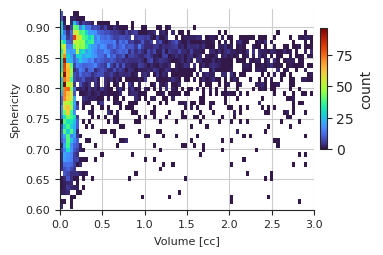

In [7]:
print("Figure 2 - E")
Sphericity_lb = 0.60
Sphericity_ub = 0.93

#df_grouped.to_csv('./Fig/Figure_2_E.csv')
df_grouped = pd.read_csv('./Fig/Figure_2_E.csv')

sns.set_style("ticks", {'axes.grid': True})
jointplot_hist = sns.jointplot(
    x="Volume (cm3)", y="Sphericity", data=df_grouped, cmap='turbo', kind="hist")
jointplot_hist.ax_joint.tick_params(axis='both', which='both', labelsize=8)
jointplot_hist.fig.colorbar(jointplot_hist.ax_joint.collections[0],
                            ax=[jointplot_hist.ax_joint,
                                jointplot_hist.ax_marg_y,
                                jointplot_hist.ax_marg_x],
                            use_gridspec=True,
                            orientation='vertical',
                            shrink=.5,
                            pad=-.15,
                            label="count"
                            )

jointplot_hist.ax_marg_x.remove()
jointplot_hist.ax_marg_y.remove()
jointplot_hist.fig.set_size_inches((9*0.393701, 7*0.393701))
plt.xlim(0, 3)
plt.ylim(Sphericity_lb, Sphericity_ub)
plt.xlabel("Volume [cc]", fontsize=8)
plt.ylabel("Sphericity", fontsize=8)
plt.savefig('./Fig/Figure_2_E.eps', bbox_inches="tight")
plt.savefig('./Fig/Figure_2_E.png', bbox_inches="tight")
plt.show()


## Figure 3 B & C

Figure 3 - B


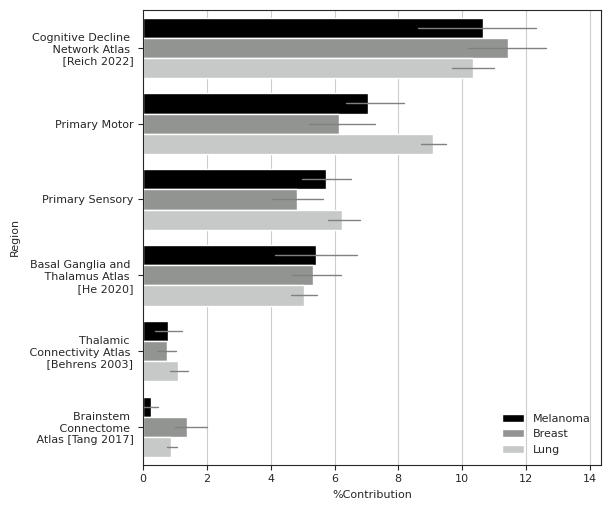

Bar                                                          mean                 low_ci               upp_ci              
Melanoma_Cognitive Decline 
 Network Atlas 
 [Reich 2022]    10.64256318994785    8.619233029679693    12.304006968641113  
Melanoma_Primary Motor                                       7.047145167920954    6.34873990736465     8.194263540649082   
Melanoma_Primary Sensory                                     5.7433153368724925   4.9753066319331385   6.5113240418118465  
Melanoma_Basal Ganglia and 
 Thalamus Atlas 
 [He 2020]      5.425437979434453    4.133510688388737    6.699077125906394   
Melanoma_Thalamic 
 Connectivity Atlas 
 [Behrens 2003]      0.7921157508837496   0.37501924072597004  1.2092122610415292  
Melanoma_Brainstem 
 Connectome 
 Atlas [Tang 2017]          0.23378575276716623  0.0                  0.46757150553433247 
Breast_Cognitive Decline 
 Network Atlas 
 [Reich 2022]      11.426481099680576   10.173266426675394   12.618788896572163  
Breast_P

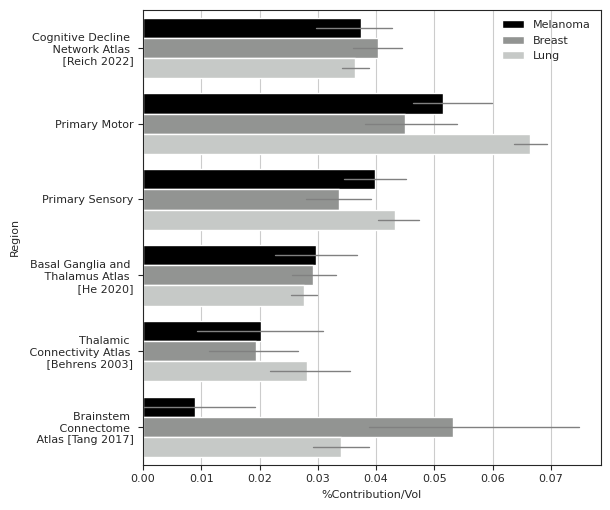

Bar                                                          mean                 low_ci               upp_ci              
Melanoma_Cognitive Decline 
 Network Atlas 
 [Reich 2022]    0.03747236265478395  0.029666436401997676 0.04264049000894039 
Melanoma_Primary Motor                                       0.05149464507585528  0.0463912833379464   0.059876827088015325
Melanoma_Primary Sensory                                     0.039853690492488276 0.03452436771863945  0.0451830132663371  
Melanoma_Basal Ganglia and 
 Thalamus Atlas 
 [He 2020]      0.0296853225696082   0.022616533189553378 0.036654048236294604
Melanoma_Thalamic 
 Connectivity Atlas 
 [Behrens 2003]      0.0202659712143414   0.00925460902209355  0.0309372220498779  
Melanoma_Brainstem 
 Connectome 
 Atlas [Tang 2017]          0.008983467290469026 0.0                  0.019234323910624525
Breast_Cognitive Decline 
 Network Atlas 
 [Reich 2022]      0.04023253007693563  0.03603442578910315  0.0444306343647681  
Breast_P

In [8]:
print("Figure 3 - B")
#df_to_plot.to_csv('./Fig/Figure_3_B.csv')
df_to_plot = pd.read_csv('./Fig/Figure_3_B.csv')
order = region_order(df_to_plot,total=mets_total)
sns.set_style("ticks", {'axes.grid': True})
f, ax = plt.subplots(figsize=(15*0.393701, 15*0.393701)) 
ax = sns.barplot(data=df_to_plot, y="Region", hue="PRIMARY", x="%_0", palette=["black", "#929591", "#C5C9C7"], errwidth=1, errcolor="#808080", order=order)
ax.legend(ncol=1, loc="lower right", frameon=False, fontsize=8)
ax.set_xlim(0, df_to_plot["%_0"].max()+1)
ax.set_xlabel("%Contribution", fontsize=8)
ax.set_ylabel("Region", fontsize=8)
ax.tick_params(labelsize=8)
plt.savefig('./Fig/Figure_3_B.eps', bbox_inches="tight")
plt.savefig('./Fig/Figure_3_B.png', bbox_inches="tight")
plt.show()
print_barplot_values(ax) 


print("Figure 3 - C")
df_to_plot = pd.read_csv('./Fig/Figure_3_C.csv')
sns.set_style("ticks", {'axes.grid': True})
f, ax = plt.subplots(figsize=(15*0.393701, 15*0.393701))
sns.set_color_codes("muted")
sns.barplot(y=df_to_plot["Region"], x=df_to_plot["%_0_vol"], hue=df_to_plot["PRIMARY"],
            data=df_to_plot, palette=["black", "#929591", "#C5C9C7"], errwidth=1, errcolor="#808080", order=order)
ax.legend(ncol=1, loc="best", frameon=False,
          fontsize=8) 
ax.set_xlabel("%Contribution/Vol", fontsize=8)
ax.set_ylabel("Region", fontsize=8)
ax.tick_params(labelsize=8)
plt.savefig('./Fig/Figure_3_C.eps')
plt.savefig('./Fig/Figure_3_C.png')
plt.show()
print_barplot_values(ax) 

# Figure 4 B & C

Figure 4 - B


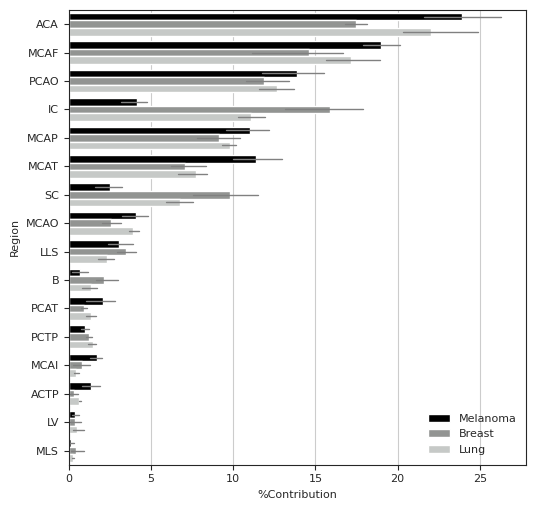

Bar                                                          mean                 low_ci               upp_ci              
Melanoma_ACA                                                 23.93532601070068    21.61818003722206    26.252471984179305  
Melanoma_MCAF                                                18.99480485034592    17.920340309822016   20.136993968906985  
Melanoma_PCAO                                                13.899139972641295   11.770470383275262   15.537826983610117  
Melanoma_IC                                                  4.1320097226650265   3.1594312082116955   4.762954256048585   
Melanoma_MCAP                                                10.993461793307517   9.549510311705435    12.173344947735192  
Melanoma_MCAT                                                11.396986382293465   9.969159054524908    12.984866294446077  
Melanoma_SC                                                  2.5269295706226353   1.6232696110744889   3.2393292682926824  
Melanoma

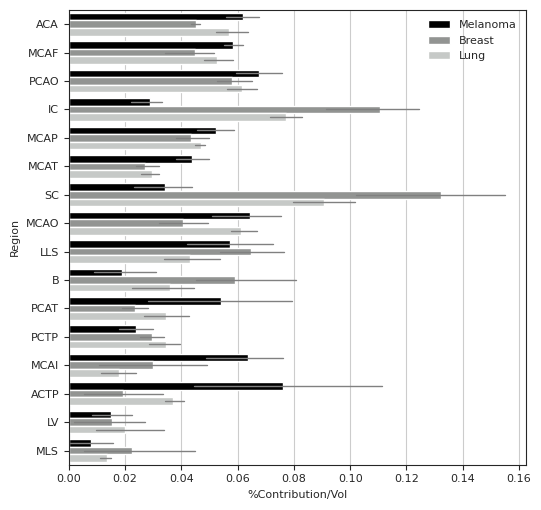

Bar                                                          mean                 low_ci               upp_ci              
Melanoma_ACA                                                 0.06174691207911723  0.055769278491218724 0.06772454566701572 
Melanoma_MCAF                                                0.058433327335652596 0.05512797417716299  0.06194702022009853 
Melanoma_PCAO                                                0.06767919039305684  0.05928491922504744  0.07565846180325131 
Melanoma_IC                                                  0.028763424333751182 0.021993186510818944 0.03315550628971205 
Melanoma_MCAP                                                0.05246398969809307  0.045573034230231665 0.058874180830987416
Melanoma_MCAT                                                0.043732632334994075 0.038253758756609246 0.04982566132186549 
Melanoma_SC                                                  0.034043725522359215 0.023122959050648463 0.04364143653561666 
Melanoma

In [9]:
print("Figure 4 - B")
#df_to_plot.to_csv('./Fig/Figure_4_B.csv')
df_to_plot = pd.read_csv('./Fig/Figure_4_B.csv')
order = region_order(df_to_plot,total=mets_total)
sns.set_style("ticks", {'axes.grid': True})
f, ax = plt.subplots(figsize=(15*0.393701, 15*0.393701)) 
ax = sns.barplot(data=df_to_plot, y="Region", hue="PRIMARY", x="%_0", palette=["black", "#929591", "#C5C9C7"], errwidth=1, errcolor="#808080", order=order)
ax.legend(ncol=1, loc="lower right", frameon=False, fontsize=8)
ax.set_xlim(0, df_to_plot["%_0"].max()+1)
ax.set_xlabel("%Contribution", fontsize=8)
ax.set_ylabel("Region", fontsize=8)
ax.tick_params(labelsize=8)
plt.savefig('./Fig/Figure_4_B.eps', bbox_inches="tight")
plt.savefig('./Fig/Figure_4_B.png', bbox_inches="tight")
plt.show()
print_barplot_values(ax)


print("Figure 4 - C")
#df_to_plot.to_csv('./Fig/Figure_4_C.csv')
df_to_plot = pd.read_csv('./Fig/Figure_4_C.csv')
sns.set_style("ticks", {'axes.grid': True})
f, ax = plt.subplots(figsize=(15*0.393701, 15*0.393701))
sns.set_color_codes("muted")
sns.barplot(y=df_to_plot["Region"], x=df_to_plot["%_0"]*1000/df_to_plot["volume"], hue=df_to_plot["PRIMARY"],
            data=df_to_plot, palette=["black", "#929591", "#C5C9C7"], errwidth=1, errcolor="#808080", order=order)
ax.legend(ncol=1, loc="best", frameon=False,
          fontsize=8)
ax.set_xlabel("%Contribution/Vol", fontsize=8)
ax.set_ylabel("Region", fontsize=8)
ax.tick_params(labelsize=8)
plt.savefig('./Fig/Figure_4_C.eps', bbox_inches="tight")
plt.savefig('./Fig/Figure_4_C.png', bbox_inches="tight")
plt.show()
print_barplot_values(ax)


# Figure 4 B Donut charts

Figure 4 B Donut charts - Lung


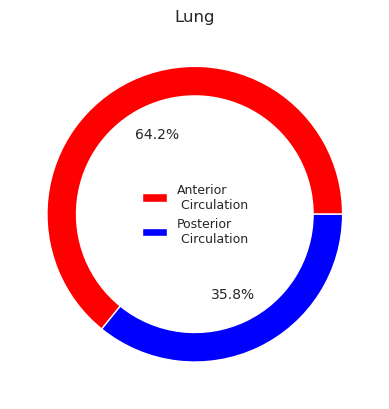

Figure 4 B Donut charts - Melanoma


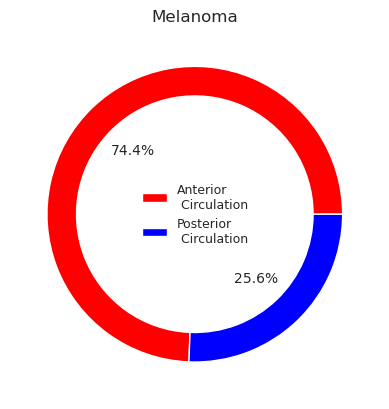

Figure 4 B Donut charts - Breast


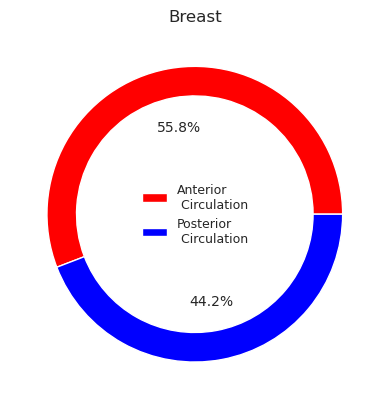

In [10]:
print("Figure 4 B Donut charts - Lung")
#df_mets_inst_totals.to_csv('./Fig/Figure_4_B_Donut_charts_Lung.csv')
df_mets_inst_totals = pd.read_csv('./Fig/Figure_4_B_Donut_charts_Lung.csv')

plt.pie(df_mets_inst_totals["%"], labels=["", ""], colors=[
        'red', 'blue'], wedgeprops={'width': 0.2, 'edgecolor': 'white'}, autopct='%1.1f%%')
plt.legend(labels=df_mets_inst_totals["Region"],
           ncol=1, loc="center", frameon=False, fontsize=9)
plt.title("Lung")
plt.savefig('./Fig/Figure_4_B_Donut_charts_Lung.eps', bbox_inches="tight")
plt.savefig('./Fig/Figure_4_B_Donut_charts_Lung.png', bbox_inches="tight")
plt.show()


print("Figure 4 B Donut charts - Melanoma")
#df_mets_inst_totals.to_csv('./Fig/Figure_4_B_Donut_charts_Melanoma.csv')
df_mets_inst_totals = pd.read_csv('./Fig/Figure_4_B_Donut_charts_Melanoma.csv')

plt.pie(df_mets_inst_totals["%"], labels=["", ""], colors=[
        'red', 'blue'], wedgeprops={'width': 0.2, 'edgecolor': 'white'}, autopct='%1.1f%%')
plt.legend(labels=df_mets_inst_totals["Region"],
           ncol=1, loc="center", frameon=False, fontsize=9)
plt.title("Melanoma")
plt.savefig('./Fig/Figure_4_B_Donut_charts_Melanoma.eps', bbox_inches="tight")
plt.savefig('./Fig/Figure_4_B_Donut_charts_Melanoma.png', bbox_inches="tight")
plt.show()


print("Figure 4 B Donut charts - Breast")
#df_mets_inst_totals.to_csv('./Fig/Figure_4_B_Donut_charts_Breast.csv')
df_mets_inst_totals = pd.read_csv('./Fig/Figure_4_B_Donut_charts_Breast.csv')
plt.pie(df_mets_inst_totals["%"], labels=["", ""], colors=[
        'red', 'blue'], wedgeprops={'width': 0.2, 'edgecolor': 'white'}, autopct='%1.1f%%')
plt.legend(labels=df_mets_inst_totals["Region"],
           ncol=1, loc="center", frameon=False, fontsize=9)
plt.title("Breast")
plt.savefig('./Fig/Figure_4_B_Donut_charts_Breast.eps', bbox_inches="tight")
plt.savefig('./Fig/Figure_4_B_Donut_charts_Breast.png', bbox_inches="tight")
plt.show()

# Supplemental Figure 2 

Supplemental Figure 2


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


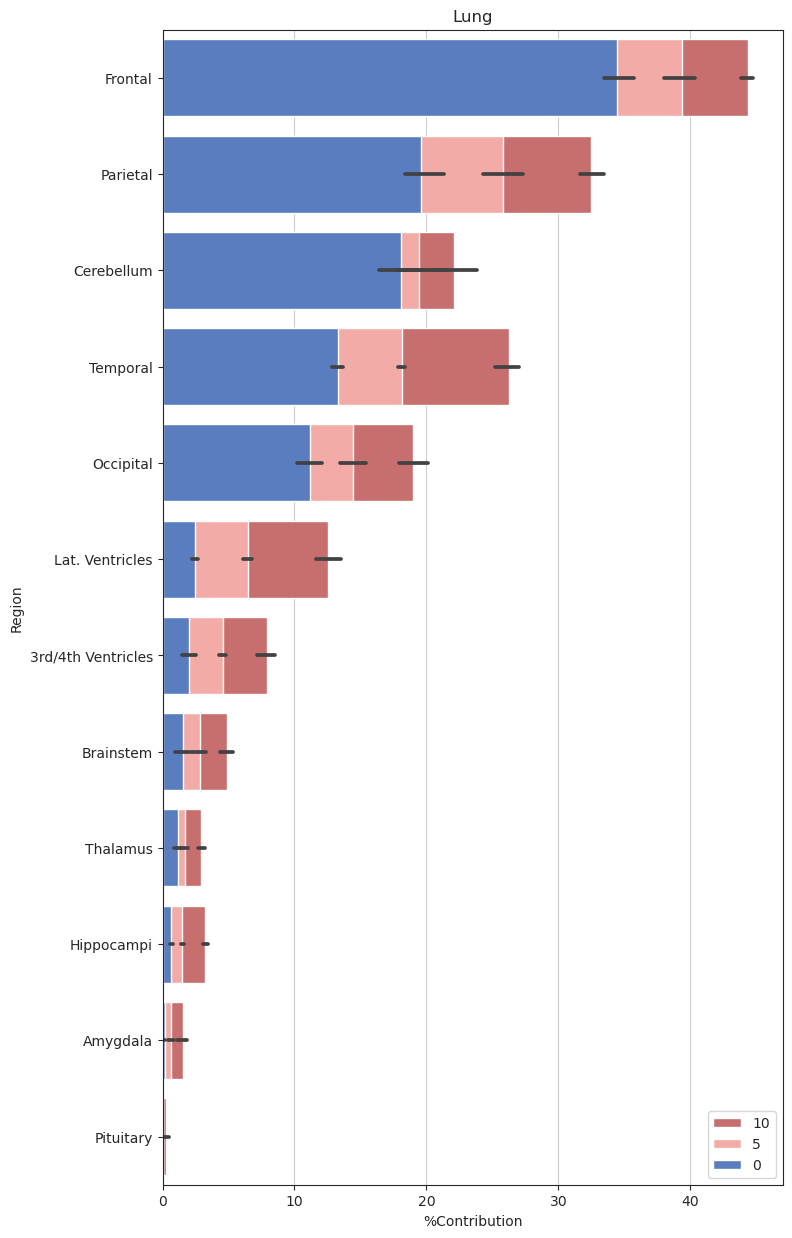

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


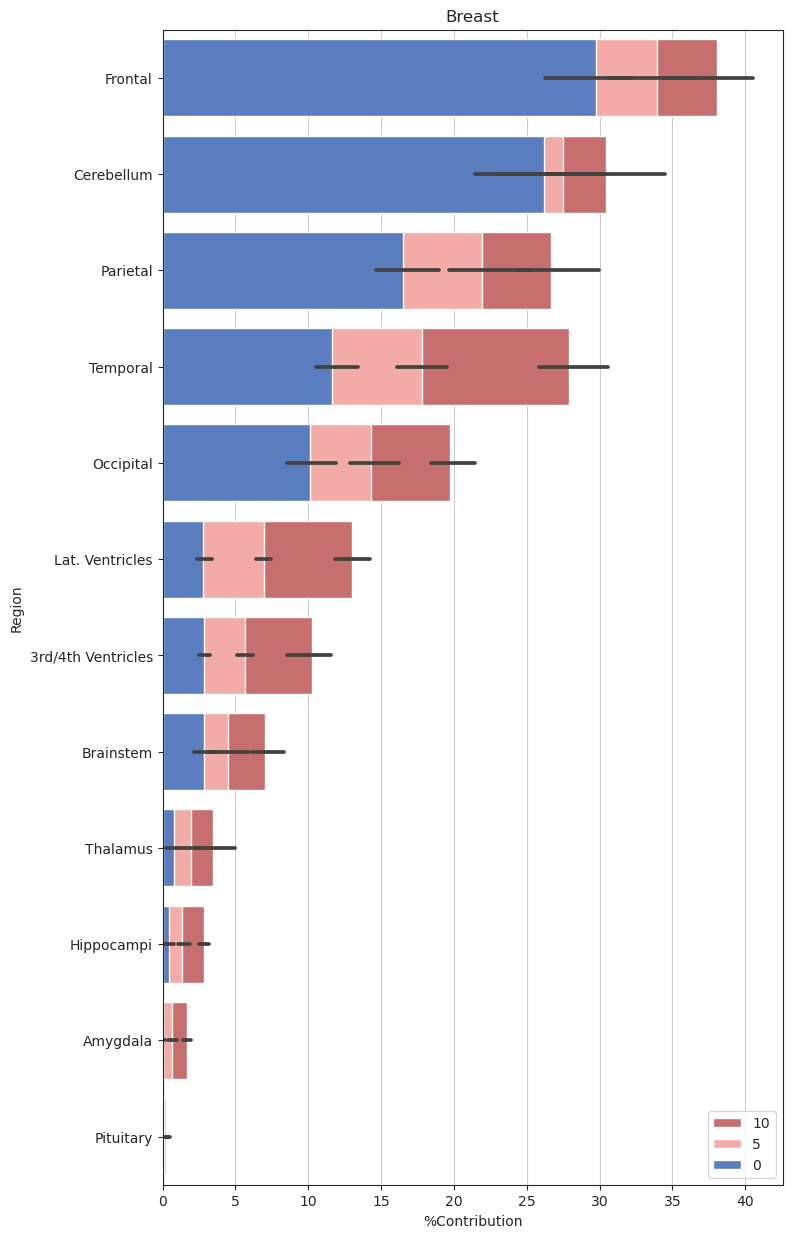

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


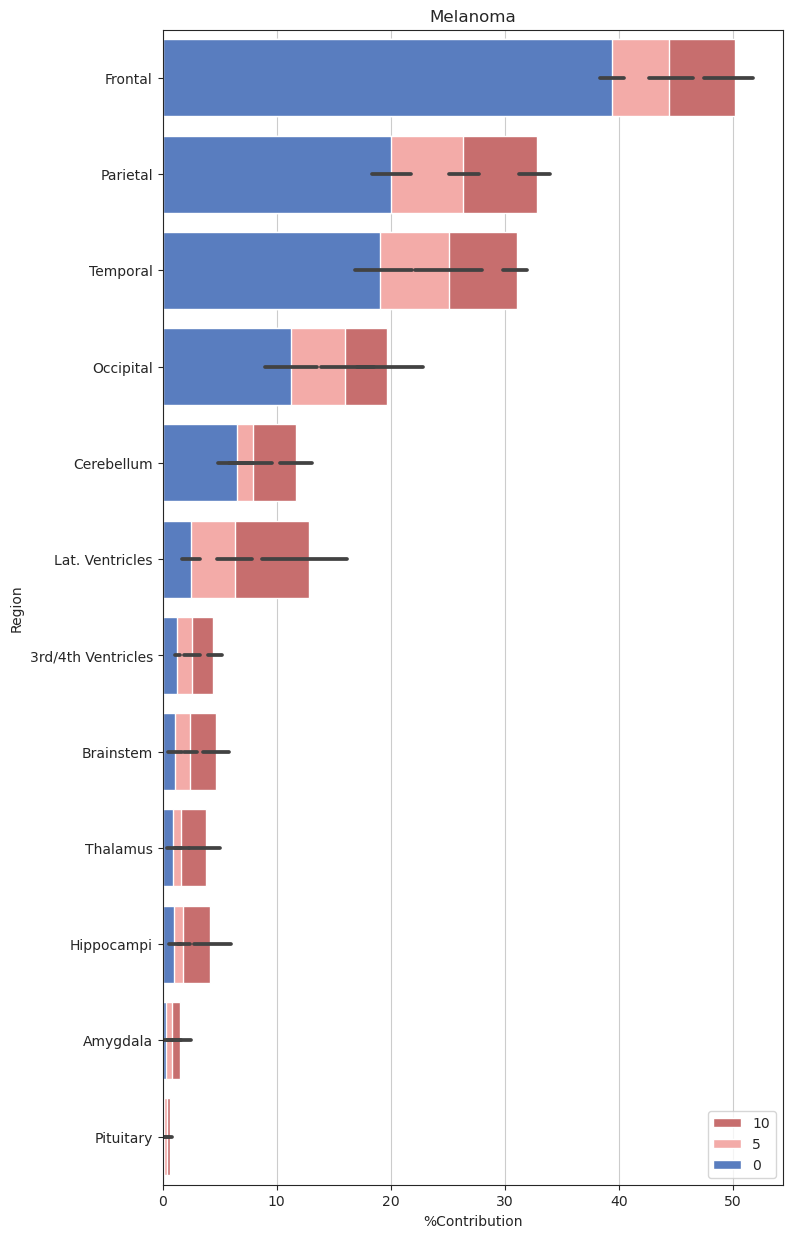

In [11]:
print("Supplemental Figure 2")
inst_list = ["Lung", "Breast","Melanoma"]
#df_to_plot.to_csv('./Fig/Supplemental_Figure_2.csv')
df_to_plot = pd.read_csv('./Fig/Supplemental_Figure_2.csv')

for inst_name in inst_list:
    sns.set_style("ticks",{'axes.grid' : True})
    f, ax = plt.subplots(figsize=(8, 15))
    sns.set_color_codes("muted")
    df_to_plot_case = df_to_plot[df_to_plot["PRIMARY"]==inst_name].copy()
    df_to_plot_case.reset_index(drop=True, inplace=True)
    order = region_order(df_to_plot_case,total=mets_total)
    sns.barplot(y=df_to_plot_case["Region"], x=df_to_plot_case["%_10"], data=df_to_plot_case,label="10", color="r", order=order)
    sns.set_color_codes("pastel")
    sns.barplot(y=df_to_plot_case["Region"], x=df_to_plot_case["%_5"], data=df_to_plot_case,label="5", color="r", order=order)
    sns.set_color_codes("muted")
    sns.barplot(y=df_to_plot_case["Region"], x=df_to_plot_case["%_0"], data=df_to_plot_case,label="0", color="b", order=order)
    ax.legend(ncol=1, loc="lower right", frameon=True)
    ax.set(xlabel="%Contribution",ylabel="Region")
    ax.set_title(inst_name)
    plt.savefig('./Fig/Supplemental_Figure_2_'+ inst_name + '.eps')
    plt.savefig('./Fig/Supplemental_Figure_2_'+ inst_name + '.png')
    plt.show()


# Supplemental Figure 3 A & B

Supplemental Figure 3 A


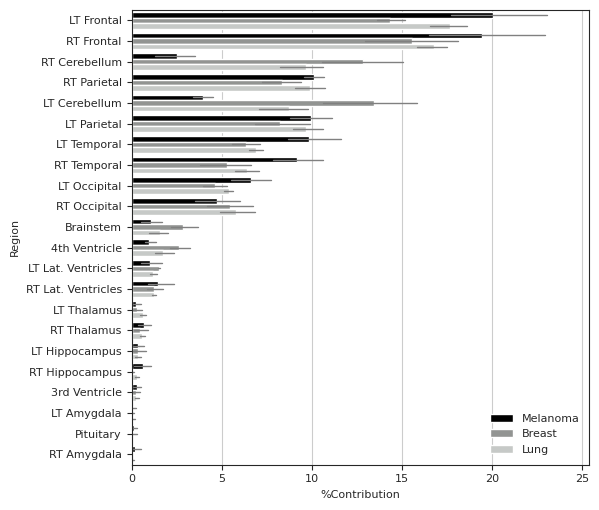

Bar                                                          mean                 low_ci               upp_ci              
Melanoma_LT Frontal                                          20.05182686911125    17.724556763639928   23.026017633487143  
Melanoma_RT Frontal                                          19.460163908766248   16.514399307844428   22.9111568224116    
Melanoma_RT Cerebellum                                       2.527099463396481    1.2907288821922966   3.5178059800176316  
Melanoma_RT Parietal                                         10.104425021869188   9.549006838163464    10.659843205574912  
Melanoma_LT Cerebellum                                       3.9875671818075578   3.4313494679348335   4.543784895680282   
Melanoma_LT Parietal                                         9.955195050377611    8.809562574622817    11.100827526132406  
Melanoma_LT Temporal                                         9.838159611796844    8.652974620962425    11.602157759959699  
Melanoma

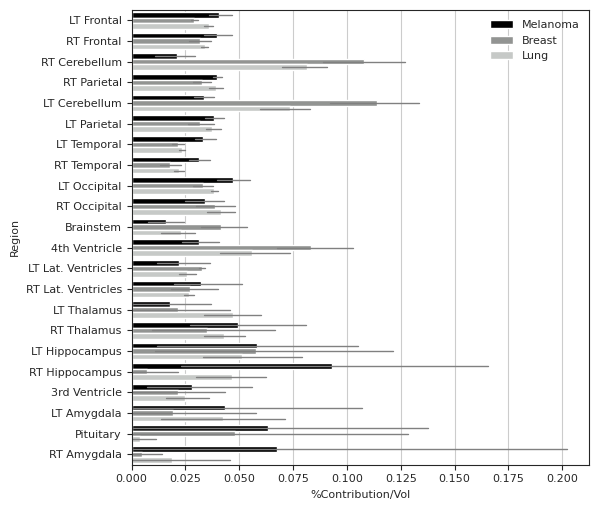

Bar                                                          mean                 low_ci               upp_ci              
Melanoma_LT Frontal                                          0.04064949515922051  0.035931603093621    0.04667883871321534 
Melanoma_RT Frontal                                          0.039789570780810066 0.03376646071650155  0.04684570491438281 
Melanoma_RT Cerebellum                                       0.021211709740857003 0.010833988451885618 0.029527401059432683
Melanoma_RT Parietal                                         0.039800317561463336 0.03761258099624018  0.04198805412668649 
Melanoma_LT Cerebellum                                       0.03366171857004523  0.02896631325286876  0.038357123887221706
Melanoma_LT Parietal                                         0.03849560741196109  0.03406557687997501  0.043020373290071634
Melanoma_LT Temporal                                         0.03339746896169043  0.029374137311552206 0.03938568990202833 
Melanoma

In [12]:
print("Supplemental Figure 3 A")
#df_to_plot.to_csv('./Fig/Supplemental_Figure_3_A.csv')
df_to_plot = pd.read_csv('./Fig/Supplemental_Figure_3_A.csv')
order = region_order(df_to_plot,total=mets_total)
sns.set_style("ticks", {'axes.grid': True})
f, ax = plt.subplots(figsize=(15*0.393701, 15*0.393701))
ax = sns.barplot(data=df_to_plot, y="Region", hue="PRIMARY", x="%_0", palette=["black", "#929591", "#C5C9C7"], errwidth=1, errcolor="#808080", order=order)
ax.legend(ncol=1, loc="lower right", frameon=False, fontsize=8)
ax.set_xlim(0, df_to_plot["%_0"].max()+1)
ax.set_xlabel("%Contribution", fontsize=8)
ax.set_ylabel("Region", fontsize=8)
ax.tick_params(labelsize=8)
plt.savefig('./Fig/Supplemental_Figure_3_A.eps', bbox_inches="tight")
plt.savefig('./Fig/Supplemental_Figure_3_A.png', bbox_inches="tight")
plt.show()
print_barplot_values(ax)  


print("Supplemental Figure 3 B")
#df_to_plot.to_csv('./Fig/Supplemental_Figure_3_B.csv')
df_to_plot = pd.read_csv('./Fig/Supplemental_Figure_3_B.csv')
sns.set_style("ticks", {'axes.grid': True})
f, ax = plt.subplots(figsize=(15*0.393701, 15*0.393701))
sns.set_color_codes("muted")
sns.barplot(y=df_to_plot["Region"], x=df_to_plot["%_0"]*1000/df_to_plot["volume"], hue=df_to_plot["PRIMARY"],
            data=df_to_plot, palette=["black", "#929591", "#C5C9C7"], errwidth=1, errcolor="#808080", order=order)
ax.legend(ncol=1, loc="best", frameon=False,
          fontsize=8) 
ax.set_xlabel("%Contribution/Vol", fontsize=8)
ax.set_ylabel("Region", fontsize=8)
ax.tick_params(labelsize=8)
plt.savefig('./Fig/Supplemental_Figure_3_B.eps', bbox_inches="tight")
plt.savefig('./Fig/Supplemental_Figure_3_B.png', bbox_inches="tight")
plt.show()
print_barplot_values(ax)  


# Supplemental Figure 5

Supplemental Figure 5


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


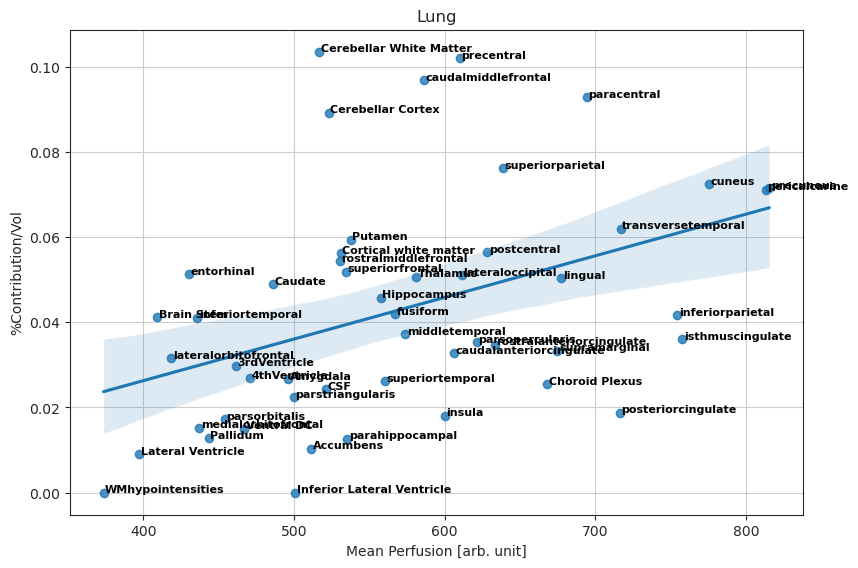

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


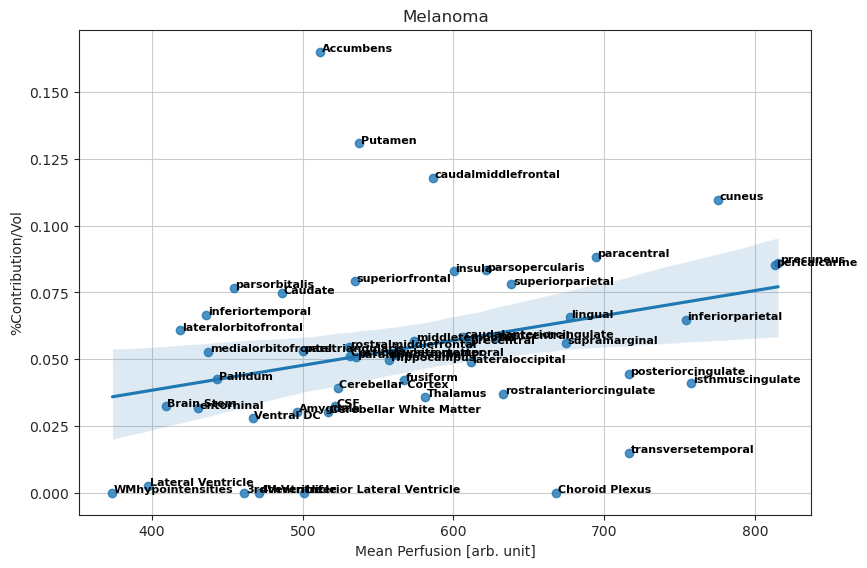

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


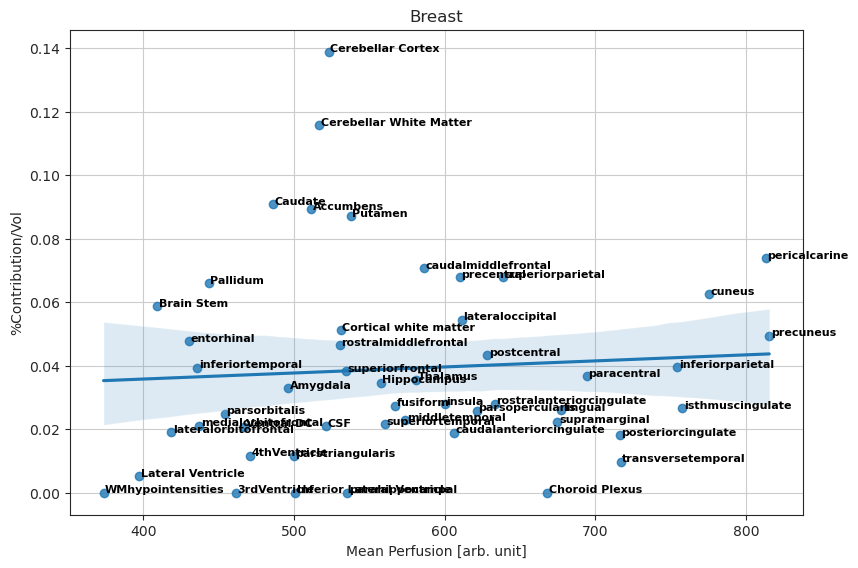

In [13]:
print("Supplemental Figure 5")
#df_to_plot.to_csv('./Fig/Supplemental_Figure_5.csv')
df_to_plot = pd.read_csv('./Fig/Supplemental_Figure_5.csv')
case = ["Lung", "Melanoma", "Breast"]
for primary in case:
    df_to_plot_primary = df_to_plot[df_to_plot["PRIMARY"]==primary].copy()
    df_to_plot_primary.reset_index(drop=True, inplace=True)
    
    plt.figure(figsize=(24*0.393701, 16*0.393701))  
    p1 = sns.regplot(x='mean_perfusion_Summation', # Horizontal axis
                     y='%Contribution/vol', # Vertical axis
                     data=df_to_plot_primary)  
    
    for line in range(0,df_to_plot_primary.shape[0]):
         p1.text(df_to_plot_primary["mean_perfusion_Summation"][line]+1, df_to_plot_primary["%Contribution/vol"][line], 
         df_to_plot_primary["Region"][line], horizontalalignment='left', 
         size=8, color='black', weight='semibold') #size='medium'
    
    plt.title(primary)
    plt.xlabel('Mean Perfusion [arb. unit]')
    plt.ylabel('%Contribution/Vol')

    df_to_plot_primary["vol[cc]"] = df_to_plot_primary["volume"]/1000
    df_to_plot_primary["%Contribution"] = df_to_plot_primary["%_0"].copy()
    df_to_plot_primary[["PRIMARY",	"Region", "vol[cc]", "%Contribution", "%Contribution/vol", "mean_perfusion_Summation"]].to_csv('./Fig/Supplemental_Figure_5_Perfusion_'+primary+'.csv') 
    
    plt.savefig('./Fig/Supplemental_Figure_5.eps', bbox_inches="tight")
    plt.savefig('./Fig/Supplemental_Figure_5.png', bbox_inches="tight")
    plt.show()